# Assignement 1


This is the assigment 1 by Mathew Lawrence 17354272

In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from os import path


We start by creating our own adabooster class. This will handle the adabooster for each scenario.

For multiple types, we will create an adabooster which classifies "that" or "not that", respectfully, and then compare them to each other.

The adabooster is a copy of tutorial one.

In [2]:
class adabooster:
    def __init__(self,debug = False, file = ""):
        self.debug = debug
        self.marginDF = None
        self.classifier_df = None
        self.file = file
        self.fitNumber = 0
        return
    def saveClassifier(self, file=""):
        if(file!=""):
            self.file = file
        self.classifier_df = pd.DataFrame(np.concatenate((self.h,np.expand_dims(self.alpha, axis=1)), axis = 1) , columns = ["Threshold","Feature","Direction","Alpha"])
        self.classifier_df.to_csv(self.file)
    def loadClassifier(self,file = ""):
        if(file!=""):
            self.file = file
        self.classifier_df = pd.read_csv(self.file,index_col = 0)
        
    def reset_params(self,Tt, datat):
        'Reset the parameters for the booster round'
        
        self.T = Tt
        self.h  = np.zeros([self.T, 3], dtype=np.float64)
        self.alpha  = np.zeros(self.T, dtype=np.float64)
        self.err  = np.ones(self.T, dtype=np.float64) * np.inf
        self.weight  = np.ones(datat.shape[0], dtype=np.float64) / datat.shape[0]
        self.dim = datat.shape[1]
        
    def calculate_decision_stump_bad(self,x, w, l):
                        # data x
                        # weights w
                        # labels l
    
        min_error = np.float64(np.inf)
        best_thresh = 0
        best_dir = 0
        interval = np.abs(x.max() - x.min()) / 100.0
        if(interval == 0):
            return 0,1,np.inf
        threshold = np.arange(x.min()-interval*2.0, x.max()+interval*2.0, interval)
        temp_err = np.float64(0)

        for d in [1, -1]:
            for thresh in threshold:

                temp = np.zeros(len(x), dtype=np.int64)
                if(d == 1):
                    temp = (x >= thresh)
                else:
                    temp = (x < thresh)

                temp = np.int64(temp)
                temp[np.where(temp == 0)] = -1

                # Initialise actual and expected labels to a perfect match( 0 = match , 1 = not a match)
                y = np.zeros(len(x), dtype=np.int64)            
                # y will be an array where 0 indictes that the sample has been correctly classified, otherwise 1
                y = np.int64(temp != l)

                # Calculate error of this weak classifier on the weighted dataset
                #========================
                #YOUR CODE HERE
                #========================
                temp_err = np.sum(y * w)

                if temp_err < min_error:
                    #========================
                    #YOUR CODE HERE
                    #========================
                    min_error = temp_err
                    best_thresh = thresh
                    best_dir = d                

        return  best_thresh, best_dir, min_error
    
    def calculate_decision_stump(self,data, feature, weight, label):
        'Calculate the desicion stump for the next booster round'
        Tp=np.float64(0); #T+ total sum of positive examples weights
        Tn=np.float64(0) #T- total sum of negative examples weights
        Sp=np.float64(0) #S+ sum of positive weights below the cuurent threshold
        Sn=np.float64(0) #S- sum of negative weights below the current threshold
        error1=np.float64(0)
        error2=np.float64(0)
        min_error=np.float64(100) 
        min_thresh=np.float64(0) 
        direction=1

        y = np.zeros(data.shape[0], dtype=np.int64)

        #get all positive weights    
        temp  = (label == 1)
        temp = np.int64(temp)
        Tp = np.sum(temp * weight)

        #get all negative weights  
        temp  = (label == -1)
        temp = np.int64(temp)
        Tn = np.sum(temp * weight)

        #sort feature values
        sorted_labels = data[:, feature].argsort()
        sorted_vector =  data[sorted_labels]

        length = len(sorted_vector)
        for i in range(length):

            #RIGHT DIRECTION THRESHOLD
            #error1 is the sum of positives up to that point + total negatives minus the sum of negatives so far
            error1 = Sp + (Tn - Sn) 
            if label[sorted_labels[i]] == -1 : 
                Sn = Sn +  weight[sorted_labels[i]]
            else :
                Sp = Sp + weight[sorted_labels[i]]

            #LEFT DIRECTION THRESHOLD
            error2 = Sn + (Tp - Sp) 

            if(min_error > error1) :
                min_error = error1
                min_thresh = sorted_vector[i, feature]
                direction = 1
            if(min_error > error2) :
                min_error = error2
                min_thresh = sorted_vector[i, feature]
                direction = -1           
        
        return min_thresh, direction, min_error
    def calculate_alpha(self,weighted_error):    
        #========================
        #YOUR CODE HERE
        #========================
        if(weighted_error == 0):
            return 1
        return  0.5 * np.log( (1.0 - weighted_error) / weighted_error )
    
    def classify_dataset_against_weak_classifier(self,x, thresh, direction):
        classification = np.zeros(len(x))

        #classifiy all samples based on the last feature
        #get actual classification
        for i in range(len(x)):
            #========================
            #YOUR CODE HERE
            #========================
            if direction == -1:
                if x[i] < thresh: classification[i] = 1
                else : classification[i] = -1
            else:
                if x[i] < thresh: classification[i] = -1
                else : classification[i] = 1    


        return classification 
    def update_weights(self,weight, alpha, classification, label):

        for i in range(len(weight)):
            #========================
            #YOUR CODE HERE
            #========================
            weight[i] =  weight[i] * np.exp( -1.0 * alpha * classification[i] * label[i] ) 

        return weight
    def normalise_weights(self,weight):

        #========================
        #YOUR CODE HERE
        #========================
        weight = weight / np.sum(weight)

        return weight 
    def fit(self, x , label ):
        # This is for future use
        if(path.exists(self.file+str(self.fitNumber)+".csv")):
            self.loadClassifier(self.file+str(self.fitNumber)+".csv")
        else:
            T = self.T
            h = self.h
            alpha = self.alpha
            err = self.err
            weight = self.weight

            #0 - for each boosting round
            for t in range(T): 
                #1 - iterate through every feature  


                for feature in range(self.dim): 
                    weighted_error = np.float64(0)

                    #========================
                    #2 - GENERATE A DECISION STUMP FOR A FEATURE
                    #YOUR CODE HERE
                    #========================
                    threshold, sign, weighted_error = self.calculate_decision_stump_bad(x[:,feature] , weight, label)
    #                 threshold, sign, weighted_error = self.calculate_decision_stump(x , feature, weight, label)
    #                 print("Iteration: ",t,"Feature: ",feature, " Weighted err: ", weighted_error)
                    #========================
                    #3 - KEEP TRACK OF THE FEATURE WITH THE LOWEST WEIGHTED ERROR
                    #YOUR CODE HERE
                    #========================        
                    if weighted_error < err[t] :
                        err[t] = weighted_error
                        h[t][0] = threshold
                        h[t][1] = feature
                        h[t][2] = sign

    #             print("---->Chosen ERR: ", err[t])
                #========================
                #4 - CALCULATE ALPHA FOR BOOSTING ROUND t
                #YOUR CODE HERE
                #========================            
                alpha[t] = self.calculate_alpha(err[t])
                #========================
                #5 - CLASSIFY ALL SAMPLES BASED ON THE SELECTED FEATURE FOR BOOSTING ROUND t
                #YOUR CODE HERE
                #======================== 
                #print(x[:, int(h[t][1]) ])
                classification = self.classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )

                #========================
                #6 - UPDATE WEIGHTS BASED ON THE CORRECTNESS OF THE CLASSIFICATION
                #YOUR CODE HERE
                #========================   
                weight = self.update_weights(weight, alpha[t], classification, label)

                #========================
                #7 - NORMALISE REASSIGNED WEIGHTS
                #YOUR CODE HERE
                #========================  
                weight = self.normalise_weights(weight )

                #--------------------------------------------
                #BOOSTING ALGORITHM DONE
                #--------------------------------------------
                if(err[t]==0):
                    break

                if (self.debug):
                    print("Round ",t, " Done!")
            self.T = T
            self.h = h
            self.alpha =  alpha
            self.err = err
            self.weight = weight 
            self.saveClassifier(self.file+str(self.fitNumber)+".csv")
        self.fitNumber = self.fitNumber+1
#         self.classifier_df = pd.DataFrame(np.concatenate((self.h,np.expand_dims(self.alpha, axis=1)), axis = 1) , columns = ["Threshold","Feature","Direction","Alpha"])
        
        
        
    def classify_sample(self,xi ):
        boost_classif = self.classifier_df
        boost_classif = boost_classif.values
        classification_sum = np.float64(0)

        for thresh, feat, sign, alpha in boost_classif:
            feat = np.int64(feat)
            temp = np.float64(0)
            if(sign == 1):
                temp = (xi[feat] >= thresh)
            else:
                temp =  (xi[feat]< thresh)

            temp = alpha*(-1 if temp == 0 else temp)


            classification_sum = classification_sum + temp


        if classification_sum >= 0:
            return 1
        else:
            return -1
    def classify_dataset(self,test_x):
        results = []
        for i in range(len(test_x)):
            results.append(self.classify_sample(test_x[i]))
        results = np.array(results)
        return results
    def score(self,test_x,test_y):
        results=self.classify_dataset(test_x)
        score = len(results[results == test_y])/len(results*100)
        print(score)
        return  score
    def sum_classifier_votes_for_each_sample(self, dataset, df):
        classifier_df = self.classifier_df
        for i in range(len(dataset)):
            classification_sum = np.float64(0)
            neg_votes = np.float64(0)
            pos_votes = np.float64(0)
            for idx, thresh, feat, sign, alpha in classifier_df.itertuples():
                #========================
                #YOUR CODE HERE
                #========================  
                feat = np.int64(feat)
                temp = np.float64(0)
                if(sign == 1):
                    temp = (dataset[i][feat] >= thresh)
                else:
                    temp =  (dataset[i][feat]< thresh)

                temp = alpha*(-1 if temp == 0 else temp)
                if temp < 0:
                    neg_votes = neg_votes+temp
                else : 
                    pos_votes = pos_votes +temp



                classification_sum = classification_sum + temp


            #========================
            #YOUR CODE HERE
            #========================  
            df['sum_alpha'].iloc[i] = classification_sum
            df['pos_votes'].iloc[i] = pos_votes
            df['neg_votes'].iloc[i] = neg_votes

        return df
    def margin_calculation(self,sign, pos, neg, tot_votes):
        #========================
        #YOUR CODE HERE
        #========================   
        margin = (pos/tot_votes if sign>0 else neg/tot_votes)

        return margin
    def margin_calculation_for_training_samples(self, sign, pos, neg, tot_votes ):  
        if np.sign(sign) < 0:
            return np.abs(neg) / tot_votes, -1
        else:
            return pos / tot_votes, 1
    def sign_of_margin(self, margin, classification, true_class_label):
        #========================
        #YOUR CODE HERE
        #========================      
        return (margin if (classification == true_class_label) else -margin)
    def calculate_margins(self,x,label):
        testing_set_df = pd.DataFrame(x)
        testing_set_df['sum_alpha'] = 0 
        testing_set_df['pos_votes'] = 0 
        testing_set_df['neg_votes'] = 0 

        testing_set_df = self.sum_classifier_votes_for_each_sample(x, testing_set_df)
#         total_alpha_votes = np.sum(self.classifier_df.Alpha)
#         testing_set_df['classification'] = 0
#         testing_set_df['margin'] = 0
#         testing_set_df['total_alpha_votes'] = total_alpha_votes
        
#         result = testing_set_df[['sum_alpha','pos_votes','neg_votes','total_alpha_votes']].apply(lambda x: self.margin_calculation_for_training_samples(*x), axis=1)
#         testing_set_df['margin'] = result.apply(lambda x: x[0])
#         testing_set_df['classification'] = result.apply(lambda x: x[1])
#         testing_set_df['true_class_label'] = label
        
#         testing_set_df['sign_of_margin'] = testing_set_df[['margin', 'classification', 'true_class_label']].apply(lambda x: self.sign_of_margin(*x), axis=1)
#         self.marginDF = testing_set_df[['sign_of_margin']]
        self.marginDF =  testing_set_df
        return testing_set_df
    def plotMargins(self):
        margin_30 = self.marginDF[["sign_of_margin"]]
        sns.kdeplot(margin_30.sign_of_margin, cumulative=True, label='classifier size 30')

In [3]:
def train_test_split(X,Y,K=3):
    'Split the data into train and test splits. They will be split into K buckets, with the K-1 bucket as the test dataset.'
    kf = KFold(n_splits=K)
    Y_correct = Y[Y==1]
    Y_incorrect = Y[Y==-1]
    X_correct = X[Y==1]
    X_incorrect = X[Y==-1]

    train_x = []
    test_x = []
    train_y = []
    test_y = []

    # Add the correct rows
    for train_index, test_index in kf.split(Y_correct):
        X_train, X_test = X_correct[train_index], X_correct[test_index]
        y_train, y_test = Y_correct[train_index], Y_correct[test_index]

        train_x.append(X_train)
        test_x.append(X_test)
        train_y.append(y_train)
        test_y.append(y_test)
    #     Add the incorrect rows
    i = 0
    for train_index, test_index in kf.split(Y_incorrect):
        X_train, X_test = X_incorrect[train_index], X_incorrect[test_index]
        y_train, y_test = Y_incorrect[train_index], Y_incorrect[test_index]

        train_x[i] = np.append(train_x[i], X_train, axis=0)   
        test_x[i] = np.append(test_x[i],X_test, axis=0)
        train_y[i] = np.append(train_y[i],y_train, axis=0)
        test_y[i]= np.append(test_y[i],y_test, axis=0)
        i = i + 1
#     Make sure that all the indexes are the same.
    minIndex =1000000000;
    for i in range(len(train_x)):
        if(train_x[i].shape[0] < minIndex):
            minIndex = train_x[i].shape[0]
    for i in range(len(train_x)):
        train_x[i] = train_x[i][:minIndex]
        train_y[i] = train_y[i][:minIndex]
        
    return \
    (train_x,
    test_x,
    train_y,
    test_y)

The SPAM dataset should be placed in its own folder. Initiate it as SPAM_X and SPAM_Y, the input and the labels.

In [4]:
spamDF = pd.read_csv("spambase.data", header = None,index_col=False)
SPAM_X = spamDF[list(range(len(spamDF.columns)-1))].values
SPAM_Y = spamDF[len(spamDF.columns)-1].apply(lambda a: 1 if a==1 else -1).values

In [5]:
print("-1: ",len(SPAM_X[SPAM_Y==-1])/len(SPAM_X))
print("1: ",len(SPAM_X[SPAM_Y==1])/len(SPAM_X))

-1:  0.6059552271245382
1:  0.39404477287546186


Clearly the SPAM dataset is skewed. we will have to make our bins with the same skewness.

In [6]:
train_x,    test_x,    train_y,    test_y = train_test_split(SPAM_X,SPAM_Y)

In [7]:
print("-1: ",len(train_y[0][train_y[0] == -1])/len(train_y[0]))
print("1: ",len(train_y[0][train_y[0] == 1])/len(train_y[0]))


-1:  0.6060013046314416
1:  0.39399869536855836


Create the dataframe for the scores for the custom and the skikit adabooster

In [8]:
scores = {}

In [9]:
rounds = 60
CUSTOM_SPAM_SCORES = []
ADABOOST_SPAM_SCORES = []

In [10]:
train_x[0].shape[1]

57

In [11]:
custSpamBoost = adabooster(False,"spam")
custSpamBoost.reset_params(rounds, train_x[0])

In [12]:

for i in range(len(train_x)):
    custSpamBoost.fit(train_x[i], train_y[i])
    CUSTOM_SPAM_SCORES.append( custSpamBoost.score(test_x[i],test_y[i]))
CUSTOM_SPAM_SCORES = np.array(CUSTOM_SPAM_SCORES)

0.9224755700325733
0.9282452707110241
0.7945205479452054


In [13]:
CUSTOM_SPAM_SCORES

array([0.92247557, 0.92824527, 0.79452055])

In [14]:
scores["cust_spam_std"] = CUSTOM_SPAM_SCORES.std()
scores["cust_spam_mean"] = CUSTOM_SPAM_SCORES.mean()

# Scikit learn adabooster Spam database

In [15]:
scores

{'cust_spam_std': 0.06172346807611869, 'cust_spam_mean': 0.8817471295629343}

In [16]:
sciSpamBoost = AdaBoostClassifier(n_estimators=rounds, random_state=0)

In [17]:
sci_spam_scores = []
for i in range(len(train_x)):
    sciSpamBoost.fit(train_x[i], train_y[i])
    sci_spam_scores.append(sciSpamBoost.score(test_x[i], test_y[i]))
sci_spam_scores = np.array(sci_spam_scores)

In [18]:
scores["sci_spam_std"] = sci_spam_scores.std()
scores["sci_spam_mean"] = sci_spam_scores.mean()

In [19]:
scores

{'cust_spam_std': 0.06172346807611869,
 'cust_spam_mean': 0.8817471295629343,
 'sci_spam_std': 0.05148765507554833,
 'sci_spam_mean': 0.91544160924376}

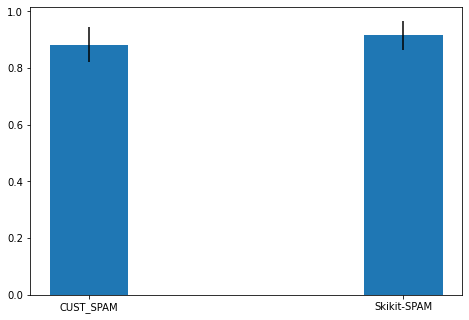

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['CUST_SPAM','Skikit-SPAM']

ax.bar(langs,[scores["cust_spam_mean"],scores["sci_spam_mean"]],yerr = [scores["cust_spam_std"],scores["sci_spam_std"]], width = 0.25)

plt.show()

## Iris Database

The iris database has got 3 classes. as such we will train 3 adaboosters and resolve conflicts using the sum of alphas

In [21]:
irisDF = pd.read_csv("iris.data", header = None,index_col=False)
irisDF[len(irisDF.columns)-1] = irisDF[len(irisDF.columns)-1].apply(lambda x: 0 if x=='Iris-setosa'  else (1 if x=='Iris-versicolor' else 2))

irisDF
X = irisDF[list(range(len(irisDF.columns)-1))].values
Y = irisDF[len(irisDF.columns)-1].values
# Y

In [22]:
irisDF

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We need a function to split the groups into however many classes there are.

In [23]:
class DataOrganizer:
    def __init__(self,df):
        self.df = df
        
    def split_into_classes(self):
        numClasses = self.df[len(self.df.columns)-1].unique()
        classDF = []
        for classID in numClasses:
            dummyDF = self.df.copy()
            dummyDF[len(dummyDF.columns)-1] = dummyDF[len(dummyDF.columns)-1].apply(lambda x: 1 if x == classID else -1)
            classDF.append(dummyDF)
        self.classDF = classDF
    def generate_train_test_splits_for_classes(self, K=3):
        'function to create a train and test split for each of the classes/adaboosters'
        classTrainTests = []
        for i in range(len(self.classDF)):

            X = self.classDF[i][list(range(len(self.classDF[i].columns)-1))].values
            Y = self.classDF[i][len(self.classDF[i].columns)-1].apply(lambda a: 1 if a==1 else -1).values

            train_x,    test_x,    train_y,    test_y = train_test_split(X,Y,K)
            
            classTrainTests.append( {
                "train_x" : train_x,
                "train_y" : train_y,
                "test_x" : test_x,
                "test_y" : test_y
            } )
#         find the minimum for the train_x
        minLen = np.inf
        for i in range(len(self.classDF)):
            for j in range(K):
                currLen = len(classTrainTests[i]["train_x"][j])
                if(minLen > currLen ):
                    minLen = currLen
        print(minLen)
        for i in range(len(self.classDF)):
            for j in range(K):
                classTrainTests[i]["train_x"][j] = classTrainTests[i]["train_x"][j][:minLen]
                classTrainTests[i]["train_y"][j] = classTrainTests[i]["train_y"][j][:minLen]
                
        minLen = np.inf   
        for i in range(len(self.classDF)):
            for j in range(K):
                currLen = len(classTrainTests[i]["test_x"][j])
                if(minLen > currLen ):
                    minLen = currLen
                    
        for i in range(len(self.classDF)):
            for j in range(K):
                classTrainTests[i]["test_x"][j] = classTrainTests[i]["test_x"][j][:minLen]
                classTrainTests[i]["test_y"][j] = classTrainTests[i]["test_y"][j][:minLen]
            
            
            
            
        self.classTrainTests = classTrainTests
        return classTrainTests
            
            
    

## Data Organizer

The data organizer is used to split the data into class DF's (binary DF's) and generates N Dataframes where N = number of classes

Next it splits the classes further into K-fold train/test splits


In other words:
1.) A DF with 3 classes is split into 3 DFs
2.) Each DF is then split into K test/train splits of the order:
Class:
    train_x;
        data
        data
        data
    train_y;
        data
        data
        data
    test_x;
        data
        data
        data
    test_y;
        data
        data
        data
     ...



In [24]:
dataGenerator = DataOrganizer(irisDF)
dataGenerator.split_into_classes()

In [25]:
classTrainTests = dataGenerator.generate_train_test_splits_for_classes()

99


In [26]:
classTrainTests

[{'train_x': [array([[5.1, 3.5, 1.4, 0.3],
          [5.7, 3.8, 1.7, 0.3],
          [5.1, 3.8, 1.5, 0.3],
          [5.4, 3.4, 1.7, 0.2],
          [5.1, 3.7, 1.5, 0.4],
          [4.6, 3.6, 1. , 0.2],
          [5.1, 3.3, 1.7, 0.5],
          [4.8, 3.4, 1.9, 0.2],
          [5. , 3. , 1.6, 0.2],
          [5. , 3.4, 1.6, 0.4],
          [5.2, 3.5, 1.5, 0.2],
          [5.2, 3.4, 1.4, 0.2],
          [4.7, 3.2, 1.6, 0.2],
          [4.8, 3.1, 1.6, 0.2],
          [5.4, 3.4, 1.5, 0.4],
          [5.2, 4.1, 1.5, 0.1],
          [5.5, 4.2, 1.4, 0.2],
          [4.9, 3.1, 1.5, 0.1],
          [5. , 3.2, 1.2, 0.2],
          [5.5, 3.5, 1.3, 0.2],
          [4.9, 3.1, 1.5, 0.1],
          [4.4, 3. , 1.3, 0.2],
          [5.1, 3.4, 1.5, 0.2],
          [5. , 3.5, 1.3, 0.3],
          [4.5, 2.3, 1.3, 0.3],
          [4.4, 3.2, 1.3, 0.2],
          [5. , 3.5, 1.6, 0.6],
          [5.1, 3.8, 1.9, 0.4],
          [4.8, 3. , 1.4, 0.3],
          [5.1, 3.8, 1.6, 0.2],
          [4.6, 3.2, 1.4, 0.2

# Multi Adabooster
Create a class which handles multiple adaboost classes and train it.

The fit function fits the data to each model and it also scores the model each round.

At the end it returns an array of scores.

In [27]:
class multiAdabooster:
    def __init__(self,numClasses, file):
        self.boosterList = []
        for i in range(numClasses):
            self.boosterList.append(adabooster(False,file+str(i)))
        
    def reset_params(self, Tt, datat):
        for i in range(len(self.boosterList)):
            self.boosterList[i].reset_params(Tt, datat)
    def fit(self,classData,rootFile = ""):
        scores = []
#     For each fold
        for i in range(len(classData[0]["train_x"])):
#         for each class fit
            for boostClass in range(len(self.boosterList)):
                train_x = classData[boostClass]["train_x"][i]
                train_y = classData[boostClass]["train_y"][i]
                self.boosterList[boostClass].fit(train_x,train_y)
#         Set the margins for the classifier
            results = []
            for boostClass in range(len(self.boosterList)):
                test_x = classData[boostClass]["test_x"][i]
                test_y = classData[boostClass]["test_y"][i]
                self.boosterList[boostClass].calculate_margins(test_x,test_y)
                results.append(self.boosterList[boostClass].classify_dataset(test_x))
#             use sum of alpha votes, if sum is greater, use that one.
            for baseClass in range(len(results)):
                baseAlphas = self.boosterList[baseClass].marginDF['sum_alpha']
                for testClass in range(len(results)):
                    if(testClass == baseClass):
                        continue
                    
                    testAlphas = self.boosterList[testClass].marginDF['sum_alpha']
                    for idx in range(len(results[baseClass])):
                        if((results[baseClass][idx] == 1) and (results[testClass][idx]==1)):
#                             get the sum of alphas
                            
                            if(baseAlphas[idx] >= testAlphas[idx]):
                                results[testClass][idx] = -1
                            else : 
                                results[baseClass][idx] = -1
            classScores = []       
            
            for boostClass in range(len(self.boosterList)):
#                 print (results[boostClass].shape, " ",classData[boostClass]["test_y"][i].shape)
                
                test_y = classData[boostClass]["test_y"][i]
                sp = len(results[boostClass][results[boostClass]==classData[boostClass]["test_y"][i]])
                tot = len(results[boostClass])
                classScores.append(sp/tot)
            scores.append(np.array(classScores).mean())
        self.scores = np.array(scores)


In [28]:
irisBooster = multiAdabooster(len(classTrainTests), "iris")

In [29]:
irisBooster.reset_params(rounds,classTrainTests[0]["train_x"][0])

In [30]:
irisBooster.fit(classTrainTests)

c:\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
irisBooster.scores

array([0.76870748, 0.76190476, 0.71428571])

In [32]:
scores["cust_iris_std"] = irisBooster.scores.std()
scores["cust_iris_mean"] = irisBooster.scores.mean()
scores["cust_iris_mean"]


0.7482993197278911

# Sklearn Iris Adabooster

This is the implementation of the Sklearn adabooster, we have to make sure that we keep the 33% distribution representation in our test and train scripts.

In [33]:
irisDF = pd.read_csv("iris.data", header = None,index_col=False)
irisDF[len(irisDF.columns)-1] = irisDF[len(irisDF.columns)-1].apply(lambda x: 0 if x=='Iris-setosa'  else (1 if x=='Iris-versicolor' else 2))

X = irisDF[list(range(len(irisDF.columns)-1))].values
Y = irisDF[len(irisDF.columns)-1].values
irisDF

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [34]:
classes = []
for i in range(len(np.unique(Y))):
    classes.append([X[Y==i],Y[Y==i]])


In [35]:
kf = KFold(n_splits=3)
train_x = []
test_x = []
train_y = []
test_y = []
for train_index, test_index in kf.split(classes[0][1]):
    X, Y = classes[0][0],classes[0][1]
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    train_x.append(X_train)
    test_x.append(X_test)
    train_y.append(y_train)
    test_y.append(y_test)
#     Add the incorrect rows
Yvals = irisDF[len(irisDF.columns)-1].values
for j in np.unique(Yvals):
    i = 0
    for train_index, test_index in kf.split(classes[j][1]):
        X, Y = classes[j][0],classes[j][1]

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        train_x[i] = np.append(train_x[i], X_train, axis=0)   
        test_x[i] = np.append(test_x[i],X_test, axis=0)
        train_y[i] = np.append(train_y[i],y_train, axis=0)
        test_y[i]= np.append(test_y[i],y_test, axis=0)
        i = i + 1


In [36]:
clf = AdaBoostClassifier(n_estimators=rounds, random_state=0)

Irisscores = []
for i in range(len(train_x)):
    
    clf.fit(train_x[i], train_y[i])
    Irisscores.append(clf.score(test_x[i], test_y[i]))
Irisscores = np.array(Irisscores)

In [37]:
scores["ski_iris_std"] = Irisscores.std()
scores["ski_iris_mean"] = Irisscores.mean()
scores["ski_iris_mean"]

0.9699754901960785

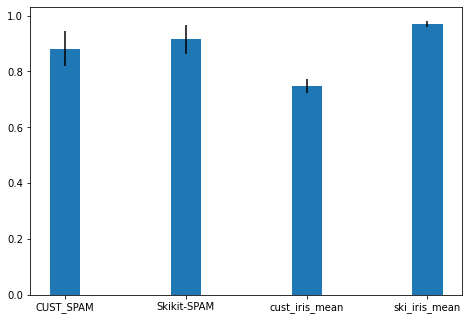

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['CUST_SPAM','Skikit-SPAM',"cust_iris_mean","ski_iris_mean"]

ax.bar(langs,[scores["cust_spam_mean"],scores["sci_spam_mean"],scores["cust_iris_mean"],scores["ski_iris_mean"]],yerr = [scores["cust_spam_std"],scores["sci_spam_std"],scores["cust_iris_std"],scores["ski_iris_std"]], width = 0.25)

plt.show()

# Optical dataset
This is a set with 10 classes and more samples.

In [39]:
opticalDF = pd.read_csv("optdigits.tra", header = None,index_col=False)


X = opticalDF[list(range(len(opticalDF.columns)-1))].values
Y = opticalDF[len(opticalDF.columns)-1].values
opticalDF

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
3819,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
3820,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
3821,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [40]:
opticalDF[0].unique()

array([0], dtype=int64)

## As you can see, there are errors in the dataset (columns are null) 

In [41]:
dropIDX = []
for i in range(len(opticalDF.columns)):
    if(len(opticalDF[i].unique()) == 1):
        print("Idx ",i,": ",opticalDF[i].unique())
        dropIDX.append(i)
opticalDF.drop(columns = dropIDX, inplace = True)        


Idx  0 :  [0]
Idx  39 :  [0]


In [42]:
opticalDF.columns = range(len(opticalDF.columns))

In [43]:
dataGenerator = DataOrganizer(opticalDF)
dataGenerator.split_into_classes()
classTrainTests = dataGenerator.generate_train_test_splits_for_classes()

2548


In [44]:
opticalDF

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,1,6,15,12,1,0,0,0,7,16,...,0,0,0,6,14,7,1,0,0,0
1,0,10,16,6,0,0,0,0,7,16,...,0,0,0,10,16,15,3,0,0,0
2,0,8,15,16,13,0,0,0,1,11,...,0,0,0,9,14,0,0,0,0,7
3,0,0,3,11,16,0,0,0,0,5,...,0,0,0,0,1,15,2,0,0,4
4,0,5,14,4,0,0,0,0,0,13,...,0,0,0,4,12,14,7,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,0,5,13,11,2,0,0,0,2,15,...,0,0,0,8,13,15,10,1,0,9
3819,0,0,1,12,1,0,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
3820,0,3,15,0,0,0,0,0,0,11,...,0,0,0,4,14,16,9,0,0,6
3821,0,6,16,2,0,0,0,0,0,15,...,0,0,0,5,16,16,16,5,0,6


In [45]:
opticalBooster = multiAdabooster(len(classTrainTests), "optical")

In [46]:
opticalBooster.reset_params(rounds,classTrainTests[0]["train_x"][0])

In [47]:
opticalBooster.fit(classTrainTests)

c:\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
opticalBooster.scores

array([0.90400628, 0.89607227, 0.8871956 ])

In [49]:
scores["cust_optical_std"] = opticalBooster.scores.std()
scores["cust_optical_mean"] = opticalBooster.scores.mean()
scores["cust_optical_mean"]

0.8957580518460331

# Scikit learn Optical Implementation
Before we can begin running the test, we need to ensure we have the correct population proportions for the model

In [50]:
X = opticalDF[list(range(len(opticalDF.columns)-1))].values
Y = opticalDF[len(opticalDF.columns)-1].values
Y

array([0, 0, 7, ..., 6, 6, 7], dtype=int64)

In [51]:
opticalDF

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,1,6,15,12,1,0,0,0,7,16,...,0,0,0,6,14,7,1,0,0,0
1,0,10,16,6,0,0,0,0,7,16,...,0,0,0,10,16,15,3,0,0,0
2,0,8,15,16,13,0,0,0,1,11,...,0,0,0,9,14,0,0,0,0,7
3,0,0,3,11,16,0,0,0,0,5,...,0,0,0,0,1,15,2,0,0,4
4,0,5,14,4,0,0,0,0,0,13,...,0,0,0,4,12,14,7,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,0,5,13,11,2,0,0,0,2,15,...,0,0,0,8,13,15,10,1,0,9
3819,0,0,1,12,1,0,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
3820,0,3,15,0,0,0,0,0,0,11,...,0,0,0,4,14,16,9,0,0,6
3821,0,6,16,2,0,0,0,0,0,15,...,0,0,0,5,16,16,16,5,0,6


In [52]:
print (np.unique(Y))
len(Y[Y==9])


[0 1 2 3 4 5 6 7 8 9]


382

In [53]:
classes = []
for i in range(len(np.unique(Y))):
    classes.append([X[Y==i],Y[Y==i]])

In [54]:
kf = KFold(n_splits=3)
train_x = []
test_x = []
train_y = []
test_y = []
for train_index, test_index in kf.split(classes[0][1]):
    X, Y = classes[0][0],classes[0][1]
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    train_x.append(X_train)
    test_x.append(X_test)
    train_y.append(y_train)
    test_y.append(y_test)
#     Add the incorrect rows
Yvals = opticalDF[len(opticalDF.columns)-1].values
for j in np.unique(Yvals):
    i = 0
    for train_index, test_index in kf.split(classes[j][1]):
        X, Y = classes[j][0],classes[j][1]

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        train_x[i] = np.append(train_x[i], X_train, axis=0)   
        test_x[i] = np.append(test_x[i],X_test, axis=0)
        train_y[i] = np.append(train_y[i],y_train, axis=0)
        test_y[i]= np.append(test_y[i],y_test, axis=0)
        i = i + 1


In [55]:
clf = AdaBoostClassifier(n_estimators=rounds, random_state=0,algorithm="SAMME")

OpticalScores = []
predictions = []
for i in range(len(train_x)):
    
    clf.fit(train_x[i], train_y[i])
    predictions.append(clf.predict(test_x[i]))
    OpticalScores.append(clf.score(test_x[i], test_y[i]))
OpticalScores = np.array(OpticalScores)

In [56]:
OpticalScores

array([0.84259259, 0.82142857, 0.81648746])

In [57]:
scores["ski_optical_std"] = OpticalScores.std()
scores["ski_optical_mean"] = OpticalScores.mean()
scores["ski_optical_mean"]

0.8268362064060989

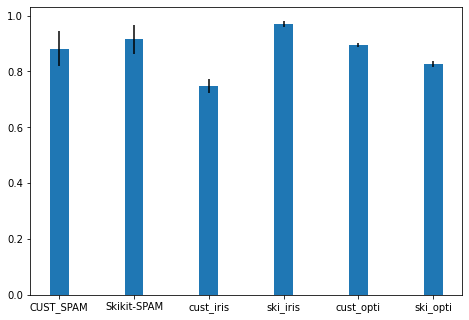

In [58]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['CUST_SPAM','Skikit-SPAM',"cust_iris","ski_iris","cust_opti","ski_opti"]

ax.bar(langs,[scores["cust_spam_mean"],scores["sci_spam_mean"],scores["cust_iris_mean"],scores["ski_iris_mean"],scores["cust_optical_mean"],scores["ski_optical_mean"]],yerr = [scores["cust_spam_std"],scores["sci_spam_std"],scores["cust_iris_std"],scores["ski_iris_std"],scores["cust_optical_std"],scores["ski_optical_std"]], width = 0.25)

plt.show()

In [59]:
penDF = pd.read_csv("pendigits.tra", header = None,index_col=False)


X = penDF[list(range(len(penDF.columns)-1))].values
Y = penDF[len(penDF.columns)-1].values
penDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,0,82,9,59,56,34,41,0,10,30,3,67,42,96,100,100,5
7490,49,100,0,70,24,56,100,65,86,85,44,77,21,38,6,0,4
7491,100,98,60,100,24,87,3,58,35,51,58,26,36,0,0,5,5
7492,59,65,91,100,84,96,72,50,51,8,0,0,45,1,100,0,1


In [60]:
dataGenerator = DataOrganizer(penDF)
dataGenerator.split_into_classes()
classTrainTests = dataGenerator.generate_train_test_splits_for_classes()

4995


In [61]:
penBooster = multiAdabooster(len(classTrainTests),"pen")

In [62]:
penBooster.reset_params(rounds,classTrainTests[0]["train_x"][0])

In [63]:
penBooster.fit(classTrainTests)

c:\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [64]:
penBooster.scores

array([0.90536644, 0.8917501 , 0.88978775])

In [65]:
scores["cust_pen_std"] = penBooster.scores.std()
scores["cust_pen_mean"] = penBooster.scores.mean()
scores["cust_pen_mean"]

0.8956347617140569

In [66]:
classes = []
for i in range(len(np.unique(Y))):
    classes.append([X[Y==i],Y[Y==i]])

In [67]:
kf = KFold(n_splits=3)
train_x = []
test_x = []
train_y = []
test_y = []
for train_index, test_index in kf.split(classes[0][1]):
    X, Y = classes[0][0],classes[0][1]
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    train_x.append(X_train)
    test_x.append(X_test)
    train_y.append(y_train)
    test_y.append(y_test)
#     Add the incorrect rows
Yvals = opticalDF[len(opticalDF.columns)-1].values
for j in np.unique(Yvals):
    i = 0
    for train_index, test_index in kf.split(classes[j][1]):
        X, Y = classes[j][0],classes[j][1]

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        train_x[i] = np.append(train_x[i], X_train, axis=0)   
        test_x[i] = np.append(test_x[i],X_test, axis=0)
        train_y[i] = np.append(train_y[i],y_train, axis=0)
        test_y[i]= np.append(test_y[i],y_test, axis=0)
        i = i + 1

In [68]:
clf = AdaBoostClassifier(n_estimators=rounds, random_state=0,algorithm="SAMME")

PenScores = []
predictions = []
for i in range(len(train_x)):
    
    clf.fit(train_x[i], train_y[i])
    predictions.append(clf.predict(test_x[i]))
    PenScores.append(clf.score(test_x[i], test_y[i]))
PenScores = np.array(OpticalScores)

In [69]:
scores["ski_pen_std"] = PenScores.std()
scores["ski_pen_mean"] = PenScores.mean()
scores["ski_pen_mean"]

0.8268362064060989

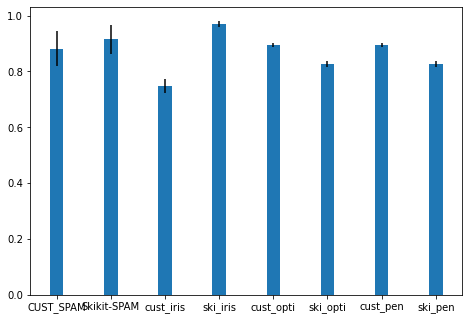

In [70]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['CUST_SPAM','Skikit-SPAM',"cust_iris","ski_iris","cust_opti","ski_opti","cust_pen","ski_pen"]

ax.bar(langs,[scores["cust_spam_mean"],scores["sci_spam_mean"],scores["cust_iris_mean"],scores["ski_iris_mean"],scores["cust_optical_mean"],scores["ski_optical_mean"], scores["cust_pen_mean"], scores["ski_pen_mean"]],yerr = [scores["cust_spam_std"],scores["sci_spam_std"],scores["cust_iris_std"],scores["ski_iris_std"],scores["cust_optical_std"],scores["ski_optical_std"],scores["cust_pen_std"],scores["ski_pen_std"]], width = 0.25)

plt.show()

(4,)   (4,)
(4,)   (4,)


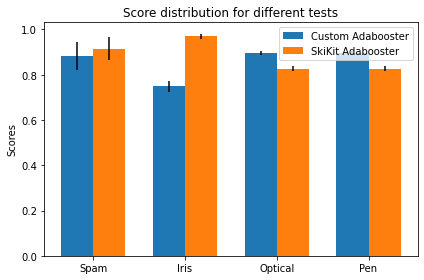

In [71]:





cust_means, cust_std = np.array([scores["cust_spam_mean"],scores["cust_iris_mean"],scores["cust_optical_mean"], scores["cust_pen_mean"]]), np.array([scores["cust_spam_std"],scores["cust_iris_std"],scores["cust_optical_std"],scores["cust_pen_std"]])
ski_means, ski_std   = np.array([scores["sci_spam_mean"], scores["ski_iris_mean"], scores["ski_optical_mean"],  scores["ski_pen_mean"]]),  np.array([scores["sci_spam_std"], scores["ski_iris_std"], scores["ski_optical_std"], scores["ski_pen_std"]])

print(cust_means.shape, ' ', cust_std.shape)
print(ski_means.shape, ' ', ski_std.shape)
ind = np.arange(len(cust_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300
langs = ['Spam','Iris',"Optical","Pen"]
rects1 = ax.bar(ind - width/2, cust_means, width, yerr=cust_std,
                label='Custom Adabooster')
rects2 = ax.bar(ind + width/2, ski_means, width, yerr=ski_std,
                label='SkiKit Adabooster ')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Score distribution for different tests')
ax.set_xticks(ind)
ax.set_xticklabels(langs)
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()





In [72]:
scores

{'cust_spam_std': 0.06172346807611869,
 'cust_spam_mean': 0.8817471295629343,
 'sci_spam_std': 0.05148765507554833,
 'sci_spam_mean': 0.91544160924376,
 'cust_iris_std': 0.02421106179598931,
 'cust_iris_mean': 0.7482993197278911,
 'ski_iris_std': 0.012038531068865509,
 'ski_iris_mean': 0.9699754901960785,
 'cust_optical_std': 0.006866528438607702,
 'cust_optical_mean': 0.8957580518460331,
 'ski_optical_std': 0.011322586178271997,
 'ski_optical_mean': 0.8268362064060989,
 'cust_pen_std': 0.006927812393346278,
 'cust_pen_mean': 0.8956347617140569,
 'ski_pen_std': 0.011322586178271997,
 'ski_pen_mean': 0.8268362064060989}